# Bifrost
FrostAura Decision Engine

## Install Dependencies
Python Kernel Version: 3.9.7

In [1]:
!pip install ta-lib xgboost

## Import Dependencies

In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import talib
from talib import RSI, BBANDS
import xgboost as xgb

## Prepare Data
Load the data produced from [FrostAura Plutus](https://github.com/faGH/fa.services.plutus).

### Data Parsing Utils

In [3]:
def get_pair_name(path: str) -> str:
    pair_name = (path
                    .split('/')[-1]
                    .split('.json')[0]
                    .split('-')[0])
    
    return pair_name

def load_path_data(path: str, frequency: str) -> pd.DataFrame:
    try:
        df = pd.read_json(path)
        df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
        df['ds'] = pd.to_datetime(df['time'], unit='ms')
        df.set_index('ds', inplace=True)
        
        return df.asfreq(freq=frequency)
    except Exception as e:
        print(f'Failed to load {path} with error "{str(e)}". Skipping.')
        return None
    
def load_plutus_pair_data_from_dir(fa_plutus_data_relative_path: str, frequency: str='1H') -> dict:
    file_names = [ f for f in listdir(fa_plutus_data_relative_path) if (isfile(join(fa_plutus_data_relative_path, f)) and '.json' in f and frequency.lower() in f.lower()) ]
    file_paths = np.array([f'{fa_plutus_data_relative_path}/{f}' for f in file_names ])
    market_data = { get_pair_name(path):load_path_data(path, frequency) for path in file_paths if load_path_data(path, frequency) is not None }
    
    return market_data

### Load Raw Pairs Data

In [4]:
fa_plutus_data_relative_path = './../../../fa.services.plutus/user_data/data/binance'
market_data = load_plutus_pair_data_from_dir(fa_plutus_data_relative_path, frequency='1H')

Failed to load ./../../../fa.services.plutus/user_data/data/binance/BOT_BTC-1h.json with error "Length mismatch: Expected axis has 0 elements, new values have 6 elements". Skipping.
Failed to load ./../../../fa.services.plutus/user_data/data/binance/BQX_BTC-1h.json with error "Length mismatch: Expected axis has 0 elements, new values have 6 elements". Skipping.
Failed to load ./../../../fa.services.plutus/user_data/data/binance/NANO_BTC-1h.json with error "Length mismatch: Expected axis has 0 elements, new values have 6 elements". Skipping.


In [5]:
# Visualize the first loaded pair.
market_data[next(iter(market_data))].head(1)

,time,open,high,low,close,volume
ds,,,,,,
2022-04-04,1649030400000,0.00523,0.005233,0.005167,0.005171,966.474


### Generate External Regressors
We calculate various market indicator values for all pairs.

#### External Regressors Utils

In [6]:
def featurize_market_data(market_data: dict) -> dict:
    # Perform the transformation for each pair.
    for pair in market_data:
        # Featurizing pair "{pair}" with seasonality.
        pair_df = market_data[pair]
        pair_df['hour'] = pair_df.apply(lambda row: row.name.hour, axis=1)
        pair_df['day'] = pair_df.apply(lambda row: row.name.day, axis=1)
        pair_df['week'] = pair_df.apply(lambda row: row.name.week, axis=1)
        pair_df['month'] = pair_df.apply(lambda row: row.name.month, axis=1)
        
        # Features from the previous entry / row / candle.
        pair_df['close_next'] = pair_df['close'].shift(1)
        
        # Featurizing pair "{pair}" with indicators.
        pair_df['sma'] = talib.SMA(pair_df['close'])
        time_periods = [ 14, 20 ]
        stds = [ 2, 3, 4 ]
        
        for period in time_periods:
            pair_df[f'rsi_tp{period}'] = RSI(pair_df['close'], timeperiod=period)
            pair_df['adx'] = talib.ADX(pair_df['high'], pair_df['low'], pair_df['close'], timeperiod=period)
            slowk, slowd = talib.STOCH(pair_df['high'], pair_df['low'], pair_df['close'], fastk_period=period)
            pair_df[f'stoch_slow_k_tp_{period}'] = slowk
            pair_df[f'stoch_slow_d_tp_{period}'] = slowd
            
            for deviation in stds:
                upper, middle, lower = BBANDS(pair_df['close'], timeperiod=period, nbdevup=deviation, nbdevdn=deviation, matype=0)
                pair_df[f'bb_upper_tp{period}_sd{deviation}'] = upper
                pair_df[f'bb_middle_tp{period}_sd{deviation}'] = middle
                pair_df[f'bb_lower_tp{period}_sd{deviation}'] = lower
                
        # We drop NANs as there will be some leading NANs due to how certain indicators are calculated. For this reason we ignore those records.
        market_data[pair] = market_data[pair]
        market_data[pair].columns = [ f'{pair}_{col}' for col in market_data[pair].columns]
        
    return market_data

#### Data Manipulation Utils

In [7]:
def split_training_test_data(data: pd.DataFrame, test_size: float=0.2) -> (pd.DataFrame, pd.DataFrame):
    train_size = 1 - test_size
    train_data = data.iloc[:int(len(data) * train_size)]
    test_data = data.iloc[int(len(data) * train_size):]
    
    return train_data, test_data

In [8]:
def concat_market_data(market_data: dict) -> pd.DataFrame:
    return pd.concat([market_data[pair] for pair in market_data])

#### Generate Dataframe With External Regressors Included

In [9]:
featurized_market_data = featurize_market_data(market_data)

In [10]:
featurized_market_data[next(iter(featurized_market_data))].head(1)

,AAVE_BTC_time,AAVE_BTC_open,AAVE_BTC_high,AAVE_BTC_low,AAVE_BTC_close,AAVE_BTC_volume,AAVE_BTC_hour,AAVE_BTC_day,AAVE_BTC_week,AAVE_BTC_month,...,AAVE_BTC_stoch_slow_d_tp_20,AAVE_BTC_bb_upper_tp20_sd2,AAVE_BTC_bb_middle_tp20_sd2,AAVE_BTC_bb_lower_tp20_sd2,AAVE_BTC_bb_upper_tp20_sd3,AAVE_BTC_bb_middle_tp20_sd3,AAVE_BTC_bb_lower_tp20_sd3,AAVE_BTC_bb_upper_tp20_sd4,AAVE_BTC_bb_middle_tp20_sd4,AAVE_BTC_bb_lower_tp20_sd4
ds,,,,,,,,,,,,,,,,,,,,,
2022-04-04,1649030400000,0.00523,0.005233,0.005167,0.005171,966.474,0,4,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
all_feature_data = concat_market_data(featurized_market_data)

In [12]:
all_feature_data_train, all_feature_data_test = split_training_test_data(all_feature_data)

print(f'Training Set: {all_feature_data_train.shape}, Test Set: {all_feature_data_test.shape}')

Training Set: (55177, 1776), Test Set: (13795, 1776)


## Forecasting Models

### Extreme Gradiant Boosting

In [13]:
model = xgb.XGBRegressor()

<AxesSubplot:xlabel='ds'>

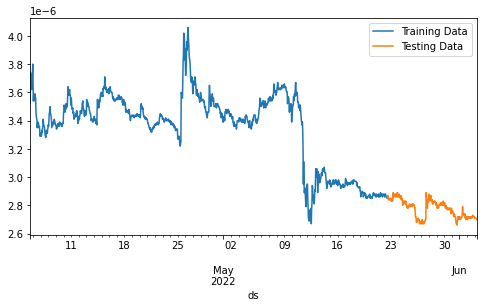

In [14]:
pair_data_train, pair_data_test = split_training_test_data(featurized_market_data['DOGE_BTC'].dropna())

pair_data_train['DOGE_BTC_close'].rename('Training Data').plot(figsize=(8,4), legend=True)
pair_data_test['DOGE_BTC_close'].rename('Testing Data').plot(legend=True)

### Facebook Prophet

In [15]:
### TEST
pair_data_train, pair_data_test = split_training_test_data(featurized_market_data['DOGE_BTC'].dropna())
### END TEST